In [1]:
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

import logging
logging.getLogger().setLevel(logging.WARNING)

from itertools import islice

import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import torch
from gluonts.torch.distributions import StudentTOutput
# from gluonts.torch.distributions.studentT import StudentTOutput
# torch.serialization.add_safe_globals([StudentTOutput])
# from gluonts.torch.modules.loss import NegativeLogLikelihood
# torch.serialization.add_safe_globals([NegativeLogLikelihood])

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt


In [2]:
def _get_lag_llama_predictions(dataset, prediction_length, num_samples=100):
    # Load the checkpoint with map_location set to 'cpu'
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'))
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    # Initialize the estimator with the required arguments
    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32,

        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=0.0005,
        
        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

         # linear positional encoding scaling
        rope_scaling={
            "type": "linear",
            "factor": max(1.0, (32 + prediction_length) / estimator_args["context_length"]),
        },
        
        batch_size=32,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 50,}, # <- lightning trainer arguments
    )


    # Create the lightning module, transformation, and predictor
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)


    # Generate forecasts and time series predictions
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor, num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss ,predictor


In [3]:
def _get_lag_llama_predictions_tuned(dataset, prediction_length, num_samples=100):
    # Load the checkpoint with map_location set to 'cpu'
    ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cpu'),weights_only=False)
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    # Initialize the estimator with the required arguments
    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=32,

        # scaling="mean",
        nonnegative_pred_samples=True,
        aug_prob=0,
        lr=0.0005,
        
        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],

         # linear positional encoding scaling
        # rope_scaling={
        #     "type": "linear",
        #     "factor": max(1.0, (32 + prediction_length) / estimator_args["context_length"]),
        # },
        
        batch_size=32,
        num_parallel_samples=num_samples,
        trainer_kwargs = {"max_epochs": 100,}, # <- lightning trainer arguments
    )
    
    predictor = estimator.train(dataset, cache_data=True, shuffle_buffer_length=1000,verbose=False)

    # Generate forecasts and time series predictions
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor, num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss ,predictor

In [4]:
df = pd.read_csv('input/sales_data4.csv')
col=['ALL_DATE','Region','SKU','QTY']
df.columns=col
df["ALL_DATE"]=pd.to_datetime(df["ALL_DATE"],format="%d-%m-%Y")
df.set_index("ALL_DATE", inplace=True)

In [5]:
df.head()

,Region,SKU,QTY
ALL_DATE,,,
2021-01-01,Hyderabad,SKU1,768.13
2021-02-01,Hyderabad,SKU1,802.64
2021-03-01,Hyderabad,SKU1,879.21
2021-04-01,Hyderabad,SKU1,131.58
2021-05-01,Hyderabad,SKU1,123.08


In [6]:
df=df[['QTY']]

In [7]:
df.shape

(36, 1)

In [8]:
def _get_lag_llama_dataset(dataset):
    # avoid mutations
    dataset = dataset.copy()

    # convert numerical columns to `float32`
    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(
            dataset[col]
        ):
            dataset[col] = dataset[col].astype("float32")

    # create a `PandasDataset`
    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset

In [9]:
train_df=df[:33]
train_dataset = _get_lag_llama_dataset(dataset=train_df)
prediction_length =3 # prediction length
train_samples = train_df.shape[0] # sampled from the distribution for each timestep

test_df=df[33:]
test_dataset = _get_lag_llama_dataset(dataset=test_df)
test_samples = train_df.shape[0] # sampled from the distribution for each timestep

In [10]:
forecasts, tss,predictor = _get_lag_llama_predictions(
    train_dataset, prediction_length, train_samples
)

In [11]:
def generate_forecasts(predictor, test_dataset):
    # Generate forecasts
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_dataset, predictor=predictor, num_samples=len(test_dataset)  # Increased samples for better estimates
    )
    test_forecasts = list(forecast_it)
    test_tss = list(ts_it)

    return test_forecasts, test_tss

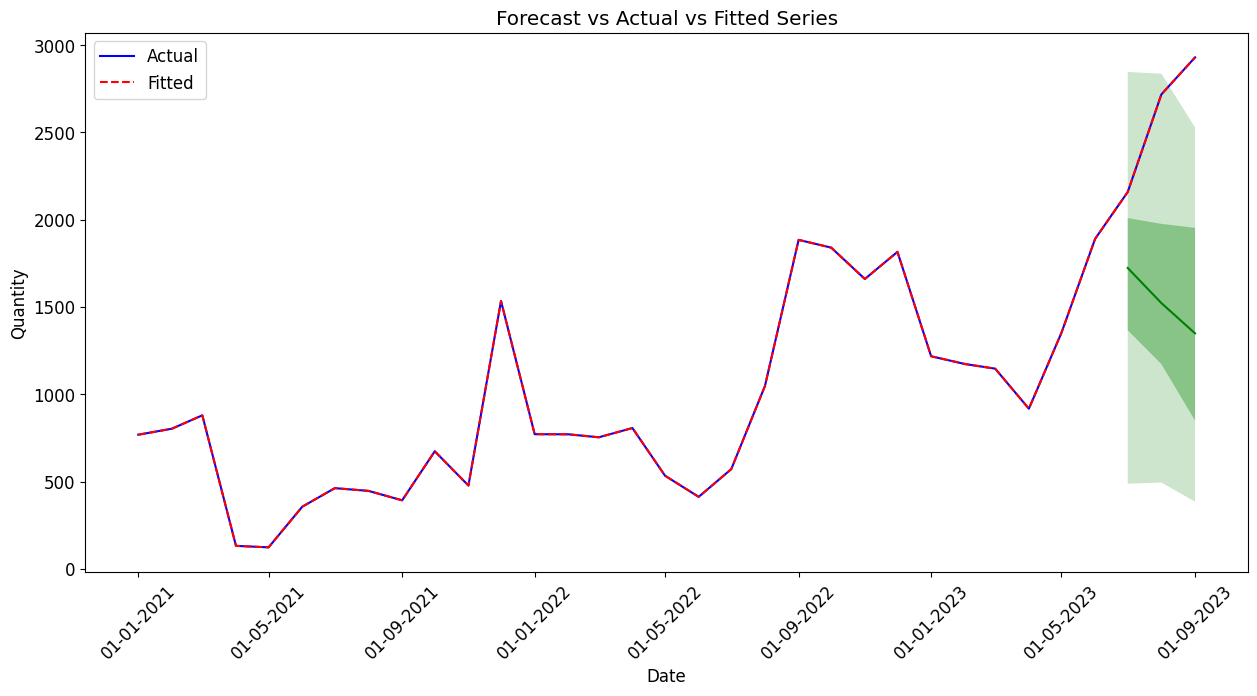

Forecasted Values: [1686.783  1591.2593 1475.4432]


In [12]:
plt.figure(figsize=(15, 7))
date_formatter = mdates.DateFormatter("%d-%m-%Y")
plt.rcParams.update({"font.size": 12})

ts = tss[0]
forecast = forecasts[0]
fitted_values = ts[:36]

plt.plot(ts.to_timestamp(), label="Actual", color='blue')
plt.plot(fitted_values.to_timestamp(), label="Fitted", color='red',linestyle='--')
forecast.plot(color="green")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.legend()
plt.title("Forecast vs Actual vs Fitted Series")

plt.show()

forecasted_values = forecast.samples.mean(axis=0)
print("Forecasted Values:", forecasted_values)
#print("Fitted Values:", fitted_values.values)

In [13]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

mae = round(agg_metrics['abs_error'],2)
mape = round(agg_metrics['MAPE']*100,2)
rmse = round(agg_metrics['RMSE'],2)
print("Lag LLama MAE: ",mae)
print("Lag LLama MAPE: ",mape)
print("Lag LLama RMSE: ",rmse)

Running evaluation: 1it [00:00, 46.08it/s]

Lag LLama MAE:  3211.45
Lag LLama MAPE:  39.37
Lag LLama RMSE:  1096.15


In [14]:
test_df=df[33:]
test_dataset = _get_lag_llama_dataset(dataset=test_df)

# Generate forecasts
test_forecasts, test_tss = generate_forecasts(predictor, test_dataset)

In [15]:
test_tss_list = [round(item,2) for sublist in test_tss[0].values.tolist() for item in sublist]

In [16]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
mae = mean_absolute_error(test_tss_list, forecasted_values)
mape = mean_absolute_percentage_error(test_tss_list, forecasted_values)
rmse = np.sqrt(mean_squared_error(test_tss_list, forecasted_values))

print("Test Evaluation Metrics:")
print("MAE:", round(mae, 2))
print("MAPE:", round(mape * 100, 2))
print("RMSE:", round(rmse, 2))


Test Evaluation Metrics:
MAE: 1805.22
MAPE: 52.79
RMSE: 1837.99


In [17]:
forecasts_tuned, tss_tuned,predictor_tuned = _get_lag_llama_predictions_tuned(
    train_dataset, prediction_length, train_samples
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentations | 0     
-----------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.797     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 7.25744 (best 7.25744), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_15\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 5.96272 (best 5.96272), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_15\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 5.70874 (best 5.70874), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_15\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 5.52752 (best 5.52752), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertat

In [18]:
evaluator = Evaluator()
agg_metrics_tuned, ts_metrics_tuned = evaluator(iter(tss_tuned), iter(forecasts_tuned))

tmae = round(agg_metrics_tuned['abs_error'],2)
tmape = round(agg_metrics_tuned['MAPE']*100,2)
trmse = round(agg_metrics_tuned['RMSE'],2)
print("Fine Tuned Lag LLama MAE: ",tmae)
print("Fine Tuned LLama MAPE: ",tmape)
print("Fine Tuned LLama RMSE: ",trmse)

Running evaluation: 1it [00:00, 27.01it/s]

Fine Tuned Lag LLama MAE:  573.37
Fine Tuned LLama MAPE:  6.67
Fine Tuned LLama RMSE:  258.51


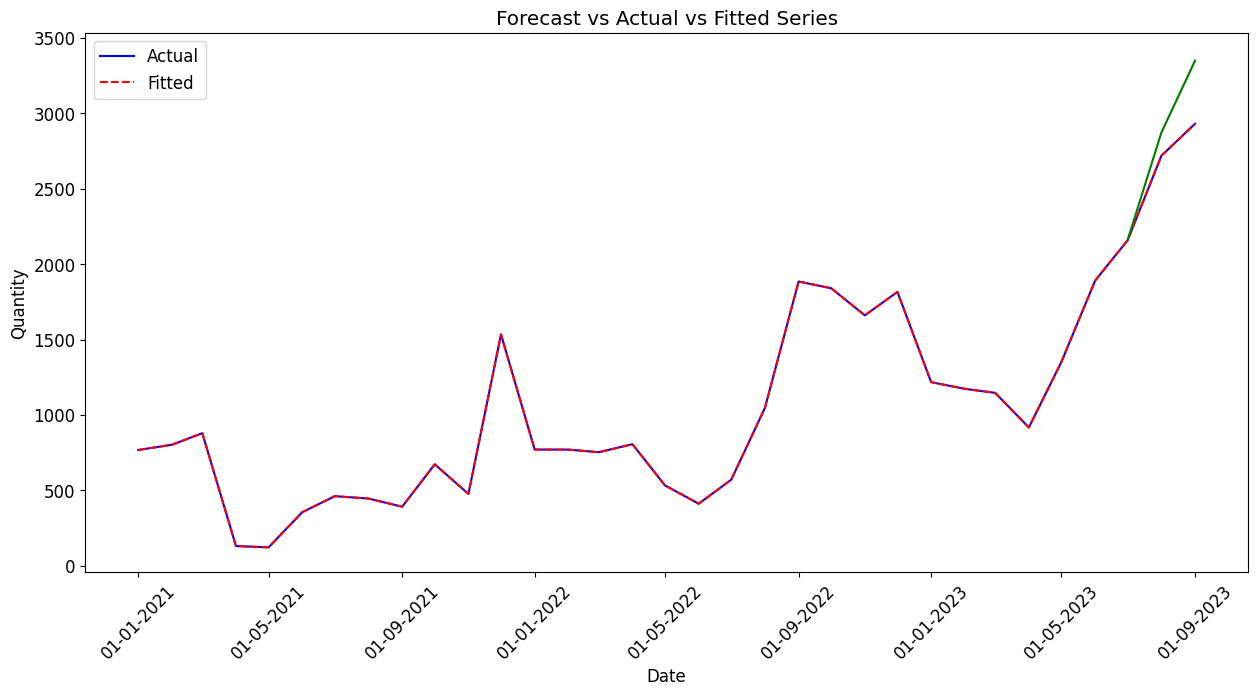

Tuned Forecasted Values: [2158.823  2873.066  3349.2449]


In [19]:
plt.figure(figsize=(15, 7))
date_formatter = mdates.DateFormatter("%d-%m-%Y")
plt.rcParams.update({"font.size": 12})

ts_tuned = tss_tuned[0]
forecast_tuned = forecasts_tuned[0]
fitted_values_tuned = ts_tuned[:36]

plt.plot(ts_tuned.to_timestamp(), label="Actual", color='blue')
plt.plot(fitted_values_tuned.to_timestamp(), label="Fitted", color='red',linestyle='--')
forecast_tuned.plot(color="green")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.legend()
plt.title("Forecast vs Actual vs Fitted Series")

plt.show()

forecast_tuned_values = forecast_tuned.samples.mean(axis=0)
print("Tuned Forecasted Values:", forecast_tuned_values)

In [20]:
test_df=df[33:]
test_dataset = _get_lag_llama_dataset(dataset=test_df)

# Generate forecasts
test_forecasts, test_tss = generate_forecasts(predictor_tuned, test_dataset)

In [21]:
test_tss_list = [round(item,2) for sublist in test_tss[0].values.tolist() for item in sublist]

In [22]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
mae = mean_absolute_error(test_tss_list, forecast_tuned_values)
mape = mean_absolute_percentage_error(test_tss_list, forecast_tuned_values)
rmse = np.sqrt(mean_squared_error(test_tss_list, forecast_tuned_values))

print("Tuned Test Evaluation Metrics:")
print("MAE:", round(mae, 2))
print("MAPE:", round(mape * 100, 2))
print("RMSE:", round(rmse, 2))


Tuned Test Evaluation Metrics:
MAE: 596.01
MAPE: 18.18
RMSE: 645.1


In [23]:
from gluonts.torch import TemporalFusionTransformerEstimator, DeepAREstimator 

tft_estimator = TemporalFusionTransformerEstimator(
  prediction_length=prediction_length, 
  context_length=32, 
  freq="MS", 
  trainer_kwargs={"max_epochs": 5}) 

deepar_estimator = DeepAREstimator(
  prediction_length=prediction_length, 
  context_length=32, 
  freq="MS", 
  trainer_kwargs={"max_epochs": 5})

In [24]:
tft_predictor = tft_estimator.train(train_dataset) 
deepar_predictor = deepar_estimator.train(train_dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                           | Params | In sizes                                                                           | Out sizes
----------------------------------------------------------------------------------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 87.4 K | [[1, 32], [1, 32], [1, 1], [1, 1], [1, 35, 1], [1, 35, 0], [1, 32, 0], [1, 32, 0]] | [1, 9, 3]
----------------------------------------------------------------------------------------------------------------------------------------------------------
87.4 K    Trainable params
0         Non-trainable params
87.4 K    Total params
0.350     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 3545.86914 (best 3545.86914), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_16\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 2477.83936 (best 2477.83936), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_16\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 1884.30591 (best 1884.30591), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_16\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 1525.29980 (best 1525.29980), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Pro

Training: |                                                                                      | 0/? [00:00<…

Epoch 0, global step 50: 'train_loss' reached 4.06782 (best 4.06782), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_17\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 3.83654 (best 3.83654), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_17\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 3.60364 (best 3.60364), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertation-2022AC05329\\lightning_logs\\version_17\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 3.51808 (best 3.51808), saving model to 'D:\\M-Tech AI & ML\\Hangout and Books\\Fourth Semester\\2022AC05329 Project-Codes\\UI-Dissertat

In [25]:
# Make predictions

tft_forecast_it, tft_ts_it = make_evaluation_predictions(
  dataset=train_dataset, 
  predictor=tft_predictor) 

deepar_forecast_it, deepar_ts_it = make_evaluation_predictions(
  dataset=train_dataset, 
  predictor=deepar_predictor) 

tft_forecasts = list(tft_forecast_it) 
tft_tss = list(tft_ts_it) 

deepar_forecasts = list(deepar_forecast_it) 
deepar_tss = list(deepar_ts_it) 

# Get evaluation metrics
tft_agg_metrics, tft_ts_metrics = evaluator(iter(tft_tss), iter(tft_forecasts)) 
deepar_agg_metrics, deepar_ts_metrics = evaluator(iter(deepar_tss), iter(deepar_forecasts)) 

The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
The mean prediction is not stored in the forecast data; the median is being returned instead. This behaviour may change in the future.
Running evaluation: 1it [00:00, 45.43it/s]
Running evaluation: 1it [00:00, 52.37it/s]


In [26]:
from prettytable import PrettyTable ,TableStyle
# Model metrics
table = PrettyTable()

# Define column names
table.field_names = ["Model", "MAE", "MAPE (%)", "RMSE"]
table.set_style(TableStyle.DOUBLE_BORDER)
# Define row values
table.add_rows([
    ["Lag LLama", round(agg_metrics['abs_error'], 2), round(agg_metrics['MAPE'] * 100, 2), round(agg_metrics['RMSE'], 2)],
    ["Fine Tune Lag LLama", round(agg_metrics_tuned['abs_error'], 2), round(agg_metrics_tuned['MAPE'] * 100, 2), round(agg_metrics_tuned['RMSE'], 2)],
    ["TFT", round(tft_agg_metrics['abs_error'], 2), round(tft_agg_metrics['MAPE'] * 100, 2), round(tft_agg_metrics['RMSE'], 2)],
    ["DEEP-AR", round(deepar_agg_metrics['abs_error'], 2), round(deepar_agg_metrics['MAPE'] * 100, 2), round(deepar_agg_metrics['RMSE'], 2)]
])

# Set table style
table.align = "c"
table.border = True
table.header = True
table.junction_char = "+"

# Print table
print(table)

╔═════════════════════╦═════════╦══════════╦═════════╗
║        Model        ║   MAE   ║ MAPE (%) ║   RMSE  ║
╠═════════════════════+═════════+══════════+═════════╣
║      Lag LLama      ║ 3211.45 ║  39.37   ║ 1096.15 ║
║ Fine Tune Lag LLama ║  573.37 ║   6.67   ║  258.51 ║
║         TFT         ║  822.53 ║  10.35   ║  288.91 ║
║       DEEP-AR       ║  833.81 ║  10.77   ║  289.93 ║
╚═════════════════════╩═════════╩══════════╩═════════╝
